<a href="https://colab.research.google.com/github/DhawaDong/LSTM-ECG/blob/main/LSTM_ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import scipy.io as sio
from os import listdir
from os.path import isfile, join
import numpy as np
import keras

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
number_of_classes = 4

In [ ]:
def discritize(x):
    answer = np.zeros((np.shape(x)[0]))
    for i in range(np.shape(x)[0]):
        max_value = max(x[i, :])
        max_index = list(x[i, :]).index(max_value)
        answer[i] = max_index
    return answer.astype(np.int)

In [ ]:
mypath = '/content/drive/MyDrive/training2017/'
onlyfiles = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f[0] == 'A')]
bats = [f for f in onlyfiles if f[7] == 'm']
mats = [f for f in bats if (np.shape(sio.loadmat(mypath + f)['val'])[1] >= 9000)]
SampleSize = np.shape(sio.loadmat(mypath + mats[0])['val'])[1]

SampleSize

18000

In [ ]:
SampleSize = 9000

In [ ]:
from sklearn.utils import shuffle
from sklearn.utils import resample

Train_data = pd.read_csv(mypath + 'REFERENCE.csv', sep=',', header=None, names=None)
df_1 = Train_data[Train_data[1]=='A']
df_2 = Train_data[Train_data[1]=='N']
df_3 = Train_data[Train_data[1]=='O']
df_4 = Train_data[Train_data[1]=='~']

df_1_upsample = resample(df_1, replace=True, n_samples=5500, random_state=123)
df_2_upsample = resample(df_2, replace=True, n_samples=5500, random_state=124)
df_3_upsample = resample(df_3, replace=True, n_samples=5500, random_state=125)
df_4_upsample = resample(df_4, replace=True, n_samples=8500, random_state=126)

training_data = pd.concat([df_1_upsample, df_2_upsample, df_3_upsample, df_4_upsample])
TrainDataSuffled = shuffle(training_data)

In [ ]:
FileList = list(TrainDataSuffled[0] + '.mat')
#len(FileList)

In [ ]:
print(df_1.shape, df_2.shape, df_3.shape, df_4.shape)

(738, 2) (5050, 2) (2456, 2) (284, 2)


In [ ]:
DelRows = []
for i in range(len(FileList)):
  #print(i)
  if (sio.loadmat(mypath + FileList[i])['val']).shape[1]<9000:
    DelRows.append(FileList[i])

len(DelRows)

5939

In [ ]:
for j in range(len(DelRows)):
  TrainDataSuffled.drop(TrainDataSuffled.loc[TrainDataSuffled[0] == DelRows[j][0:6]].index, inplace = True)

NewFileList = list(TrainDataSuffled[0]+'.mat')
len(NewFileList)

19061

In [ ]:
len(NewFileList)

19061

In [ ]:
X = np.zeros((len(NewFileList), SampleSize))
for i in range(len(NewFileList)):
    X[i, :] = sio.loadmat(mypath + NewFileList[i])['val'][0, :9000]
    #print(i)

In [ ]:
X.shape

(19061, 9000)

In [ ]:
len(NewFileList), TrainDataSuffled.shape[0]

(19061, 19061)

In [ ]:
target_train = np.zeros((len(NewFileList), 1))
#TrainDataSuffled  NewFileList
#Train_data = pd.read_csv(mypath + 'REFERENCE.csv', sep=',', header=None, names=None)
for i in range(len(NewFileList)):
    if Train_data.loc[Train_data[0] == NewFileList[i][:6], 1].values == 'N':
        target_train[i] = 0
    elif Train_data.loc[Train_data[0] == NewFileList[i][:6], 1].values == 'A':
        target_train[i] = 1
    elif Train_data.loc[Train_data[0] == NewFileList[i][:6], 1].values == 'O':
        target_train[i] = 2
    else:
        target_train[i] = 3

In [ ]:
Label_set = np.zeros((len(NewFileList), number_of_classes))
for i in range(np.shape(target_train)[0]):
    dummy = np.zeros((number_of_classes))
    dummy[int(target_train[i])] = 1
    Label_set[i, :] = dummy

In [ ]:
train_len = 0.8 #0.75
X_train = X[:int(train_len*len(NewFileList)), :]
Y_train = Label_set[:int(train_len*len(NewFileList)), :]
X_val = X[int(train_len*len(NewFileList)):, :]
Y_val = Label_set[int(train_len*len(NewFileList)):, :]

In [ ]:
X_train = numpy.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = numpy.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

In [ ]:
print(X_train.shape, X_val.shape, SampleSize)

(15248, 1, 9000) (3813, 1, 9000) 9000


In [ ]:
sum(Y_train)

array([3934., 3777., 4059., 3478.])

In [ ]:
sum(Y_val)

array([ 993.,  923., 1018.,  879.])

In [ ]:
#Model Design

In [ ]:
# Deep BiLSTM Model
batch_size = 64
x_train = X_train, y_train = Y_train
x_val = X_val, y_val = Y_val

model = Sequential()
model.add(Bidirectional(LSTM(1024, return_sequences=True), input_shape=(1, SampleSize)))
model.add(Dropout(0.25))

model.add(Bidirectional(LSTM(512, return_sequences=True)))
model.add(Dropout(0.25))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.25))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.25))

model.add(Bidirectional(LSTM(64)))
#model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
#model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
#model.add(BatchNormalization())

#output layer
model.add(Dense(number_of_classes, activation='softmax'))

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto')
adam = keras.optimizers.Adam(learning_rate = 0.00001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.001)

model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy']) #categorical_crossentropy

In [ ]:
#CNN-BiLSTM Model
batch_size = 64
x_train = np.transpose(X_train, (0, 2, 1))
y_train = Y_train

x_val = np.transpose(X_val, (0, 2, 1))
y_val = Y_val

model = Sequential()
# Three Convolutional Layers
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(SampleSize, 1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Five BLSTM Layers
#model.add(Bidirectional(LSTM(units=1024, return_sequences=True)))
#model.add(Dropout(0.2))

# Four BLSTM Layers
model.add(Bidirectional(LSTM(units=512, return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(units=256, return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(units=64)))

model.add(Dense(64, activation='relu'))
#model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
#model.add(BatchNormalization())

# Output Layer
model.add(Dense(number_of_classes, activation='softmax'))

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto')
adam = keras.optimizers.Adam(learning_rate = 0.00001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.001)

model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy']) #categorical_crossentropy

In [ ]:
model.summary()

In [ ]:
history = model.fit(x_train, y_train, epochs=2, batch_size=batch_size,
                    validation_data=(x_val, y_val), verbose=2, shuffle=False,
                    callbacks=[early_stopping])
#model.save('Keras_models/LSTM_ECG_Model_' + str(i) + '_' + str(j) + '_' + str() + '.h5')
predictions = model.predict(x_val)

Epoch 1/2
239/239 - 333s - loss: 1.3145 - accuracy: 0.3727 - val_loss: 1.2183 - val_accuracy: 0.4482 - 333s/epoch - 1s/step
Epoch 2/2
239/239 - 317s - loss: 1.1615 - accuracy: 0.4884 - val_loss: 1.0685 - val_accuracy: 0.5282 - 317s/epoch - 1s/step
120/120 [==============================] - 36s 281ms/step


In [ ]:
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, f1_score)
Y_actual = discritize(y_val)
Y_predict = discritize(predictions)

Accuracy = accuracy_score(Y_actual, Y_predict)
Precision = precision_score(Y_actual, Y_predict, average='weighted')
Recall = recall_score(Y_actual, Y_predict, average='weighted')
F1score = f1_score(Y_actual, Y_predict, average='weighted')

print(Accuracy, Precision, Recall, F1score)

0.4689221085759245 0.4588320037206777 0.4689221085759245 0.4449599521799782


<ipython-input-48-262383bcf3a5>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return answer.astype(np.int)


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


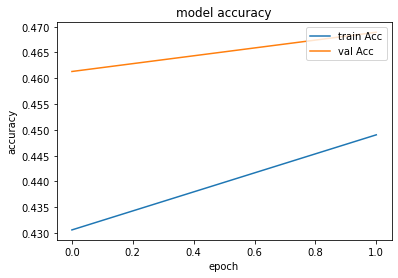

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train Acc', 'val Acc'], loc='upper right')
plt.show()

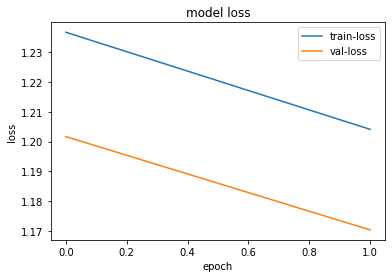

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train-loss', 'val-loss'], loc='upper right')
plt.show()

In [ ]:
predictions = model.predict(X_val)
predictions

In [ ]:
Y_actual, Y_predict

(array([3, 0, 1, ..., 3, 2, 3]), array([3, 3, 3, ..., 3, 1, 3]))

In [ ]:
cm = confusion_matrix(Y_actual, Y_predict)

In [ ]:
cm = np.array([[845,6,179,1], [2,935,2,0], [87,5,897,0],[0,0,0,854] ])
cm

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
import itertools
plot_confusion_matrix(cm, classes=['AF', 'Normal', 'Other', 'Noise'])